# **Reccomendation System: MovieLens**


**Section A: Importing libraries and configuration**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import nltk 
import re 
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
#from pandas_profiling import ProfileReport
import surprise
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from flask import Flask, request
import nltk 
import re 
import numpy as np 
from tqdm import tqdm
import heapq 
%matplotlib inline


In [2]:
#pd.set_option('display.max_column',None)
#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_seq_items',None)
#pd.set_option('display.max_colwidth', 500)
#pd.set_option('expand_frame_repr', True)

**Section 1: Content-based filtering**
1. Movies Info **->** Genre, Titles, Tags into one dataframe
2. Genres **->** Top 15 genres as 1-0 columns using Bag of Words
3. Tags **->** Embeddings using tf.hub model for universal sentence encoding
4. Titles **->** Including them in the mix will allow us to bring together sequels as embeddings extract the context
5. Applying Cosine Similarity to give out reccomendations

**Note: So far, our system does not account for movies popularity and the ratings around it**<br>
**Reason: Sorting on ratings is counter-intuitive, some people might like movies that are on average rated lower, are less popular.**


In [3]:
movie = pd.read_csv('movies.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
movie.head()

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


**Observations:**
1. Rotten Tomatoes percentage implies an aggregate, not the rating of the movie
2. Often, Rotten Tomatoes score of the movie does not coincide with the viewers' rating(viewers are forgiving)
3. The audience amount of rating can act as a popularity measurement and act as a good attribute
4. Movies with less rating counts have inflated ratings and fail to resonate with the population
5. Based on the long head-tail plottings in the case of reccomendation systems datasets, it is essential to include the influence of popularity

In [4]:
movie['rtAudienceNumRatings'].describe(include=all)

count     10197
unique     5087
top           0
freq       2622
Name: rtAudienceNumRatings, dtype: object

1. We know that there are 2500+ movies with AudienceNumRatings of 0!<br>
2. We also see dtype as object indicating something irregular with the column

In [5]:
movie[movie['rtID'].isnull()].head()

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
32,33,Wings of Courage,114952,Las alas del coraje,http://ia.media-imdb.com/images/M/MV5BMTc3ODY1...,1995,NaN,0,4,2,...,50,0,2,1,1,50,0,0,0,http://content7.flixster.com/movie/10/97/83/10...
134,143,Gospa,113200,Gospa,NaN,1995,NaN,\N,\N,\N,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
200,210,Wild Bill,114938,Wild Bill,http://ia.media-imdb.com/images/M/MV5BMTU4MDcy...,1995,NaN,\N,\N,\N,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
347,360,I Love Trouble,110093,Me gustan los líos,http://ia.media-imdb.com/images/M/MV5BMTI4MTIx...,1994,NaN,\N,\N,\N,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
395,412,The Age of Innocence,106226,La edad de la inocencia,http://ia.media-imdb.com/images/M/MV5BNzI4MjYz...,1993,NaN,\N,\N,\N,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


1. We realize that instead of eliminating on the basis \N, we were to remove by rtID being null, that would require less code and be more efficient<br>
2. We also remove all movies with 0 rtAudienceNumRatings


In [6]:
movie= movie[movie['rtID'].notnull()]
movie['rtAudienceNumRatings']=movie['rtAudienceNumRatings'].astype(int)
print("Shape after null IDs removed:")
print(movie.shape)
movie=movie[movie['rtAudienceNumRatings']!=0]
print("\nShape after non-zero remaining popularity: ")
print(movie.shape)

Shape after null IDs removed:
(9886, 21)

Shape after non-zero remaining popularity: 
(7291, 21)


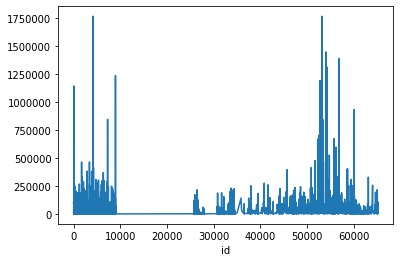

In [7]:
movie.groupby("id")['rtAudienceNumRatings'].mean().plot(logy=False)

**Earlier, I was planning on scaling number of ratings by tens, thousands, and so on but this graphs tells a seperate story and we will have to accomodate some changes**

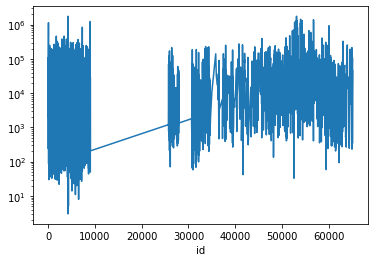

In [8]:
movie.groupby("id")['rtAudienceNumRatings'].mean().plot(logy=True)

In [9]:
popfilter1=movie[movie['rtAudienceNumRatings']>=movie['rtAudienceNumRatings'].quantile(0.75)]
mean_pop=popfilter1['rtAudienceNumRatings'].mean()
std_pop=popfilter1['rtAudienceNumRatings'].std()
print("With Quantile at 75%: ",movie['rtAudienceNumRatings'].quantile(0.75))
print("The average: ", mean_pop)
print("The standard deviation: ", std_pop)
popfilter2=movie[movie['rtAudienceNumRatings']>=movie['rtAudienceNumRatings'].quantile(0.90)]
mean_pop=popfilter2['rtAudienceNumRatings'].mean()
std_pop=popfilter2['rtAudienceNumRatings'].std()
print("\nWith Quantile at 90%: ",movie['rtAudienceNumRatings'].quantile(0.90))
print("The average: ", mean_pop)
print("The standard deviation: ", std_pop)

With Quantile at 75%:  14738.5
The average:  75169.56335710367
The standard deviation:  133036.72772066196

With Quantile at 90%:  52006.0
The average:  145987.99315068492
The standard deviation:  188954.1347706887


**Observations:** <br>
**These observations give us insight that if we filter based on popularity, we will have less but more relevant data to filter through**<br>
1. The quantile range tells us: specific amount required to make the cut
2. The insight to do this comes from the graph right this cell block
3. We note that the popularity is still in need of standardization

In [10]:
popfilter1.head()

,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
5,6,Heat,113277,Heat,http://ia.media-imdb.com/images/M/MV5BMTM1NDc4...,1995,1068182-heat,7.7,58,50,...,86,7.2,17,14,3,82,3.9,42785,92,http://content9.flixster.com/movie/26/80/26809...
9,10,GoldenEye,113189,GoldenEye,http://ia.media-imdb.com/images/M/MV5BNTE1OTEx...,1995,goldeneye,6.8,41,33,...,80,6.2,11,7,4,63,3.4,28260,78,http://content9.flixster.com/movie/26/66/26669...
15,16,Casino,112641,"Casino, de Scorsese",http://ia.media-imdb.com/images/M/MV5BMTQ0NDk5...,1995,1067987-casino,7.2,58,47,...,81,6.3,16,11,5,68,3.9,66463,91,http://content8.flixster.com/movie/10/87/61/10...


**Popularity:**
1. Logarithmic representation was better
2. convert to log
3. standardize via Column Transformer
4. Merge it with final dataframes to observe the difference<br>

Note: Thought process whilst implementing this part was to utilize this as weights and add them to each row of selected columns 


In [11]:
ss = StandardScaler()
popfilter=popfilter1[['rtAudienceNumRatings']].copy(deep=True)
popfilter.columns=['popularity']
popfilter['logarithm_base2'] = np.log2(popfilter[['popularity']])
idfilter=popfilter1[['id','rtAudienceNumRatings']].copy(deep=True)
idfilter.columns=['movieID','delet']
ct = ColumnTransformer([('popuser', StandardScaler(), ['logarithm_base2'])], remainder='passthrough')
scaled_values_popularity=ct.fit_transform(popfilter)
df_scaled = pd.DataFrame(scaled_values_popularity)
df_scaled.columns=['popularity','delet']
df_scaled['delet']=df_scaled['delet'].astype(int)
#df_scaled=df_scaled.drop(columns=['delet'])
df_scaled.head()
#gives us popularity standardized based on log transformation of popularity

,popularity,delet
0,0.929319,102338
1,-0.045244,44587
2,-0.093635,42785
3,-0.580120,28260
4,0.423016,66463


In [12]:
idfilter=idfilter.reset_index(drop=True)
popularity = pd.concat([df_scaled, idfilter], axis=1, join='inner')
popularity = popularity.drop('delet', axis=1)
popularity.head()
#gives us popularity standardized w.r.t movieID

,popularity,movieID
0,0.929319,1
1,-0.045244,2
2,-0.093635,6
3,-0.580120,10
4,0.423016,16


**We will join the scattered data into a single csv first and foremost, then begin our EDA
But even before that, we will review all data by repeating the above code block for all .dat files**

In [13]:
tags = pd.read_csv('tags.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
tags.head()#data1

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


In [14]:
movie_actors = pd.read_csv('movie_actors.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
movie_actors.head()#data2

,movieID,actorID,actorName,ranking
0,1,annie_potts,Annie Potts,10
1,1,bill_farmer,Bill Farmer,20
2,1,don_rickles,Don Rickles,3
3,1,erik_von_detten,Erik von Detten,13
4,1,greg-berg,Greg Berg,17


In [15]:
movie_countries = pd.read_csv('movie_countries.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
movie_countries.head()#data3

,movieID,country
0,1,USA
1,2,USA
2,3,USA
3,4,USA
4,5,USA


In [16]:
movie_directors = pd.read_csv('movie_directors.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
movie_directors.head()#data4

,movieID,directorID,directorName
0,1,john_lasseter,John Lasseter
1,2,joe_johnston,Joe Johnston
2,3,donald_petrie,Donald Petrie
3,4,forest_whitaker,Forest Whitaker
4,5,charles_shyer,Charles Shyer


In [17]:
movie_genres = pd.read_csv('movie_genres.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
movie_genres.head()#data5

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [18]:
movie_locations = pd.read_csv('movie_locations.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
movie_locations.head()#data6

,movieID,location1,location2,location3,location4
0,1,NaN,NaN,NaN,NaN
1,2,Canada,British Columbia,NaN,NaN
2,2,Canada,British Columbia,Delta,NaN
3,2,Canada,British Columbia,Delta,Tsawwassen
4,2,Canada,British Columbia,Maple Ridge,NaN


In [19]:
movie_tags = pd.read_csv('movie_tags.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
movie_tags.head()#data7

,movieID,tagID,tagWeight
0,1,7,1
1,1,13,3
2,1,25,3
3,1,55,3
4,1,60,1


In [20]:
user_ratedmovies = pd.read_csv('user_ratedmovies.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
user_ratedmovies.head()#data8

,userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,3,1.0,29,10,2006,23,17,16
1,75,32,4.5,29,10,2006,23,23,44
2,75,110,4.0,29,10,2006,23,30,8
3,75,160,2.0,29,10,2006,23,16,52
4,75,163,4.0,29,10,2006,23,29,30


In [21]:
user_ratedmovies_timestamps = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
user_ratedmovies_timestamps.head()#data9

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


In [22]:
user_taggedmovies = pd.read_csv('user_taggedmovies.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
user_taggedmovies.head()#data10

,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second
0,75,353,5290,29,10,2006,23,20,15
1,78,4223,5264,16,4,2007,4,43,45
2,127,1343,1544,28,8,2007,3,42,27
3,127,1343,12330,28,8,2007,3,42,27
4,127,2080,1451,28,8,2007,3,42,47


In [23]:
user_taggedmovies_timestamps = pd.read_csv('user_taggedmovies-timestamps.dat', sep='\t', header=0, skipinitialspace=False,encoding='latin-1')
user_taggedmovies_timestamps.head()#data11

,userID,movieID,tagID,timestamp
0,75,353,5290,1162160415000
1,78,4223,5264,1176691425000
2,127,1343,1544,1188265347000
3,127,1343,12330,1188265347000
4,127,2080,1451,1188265367000


From the above descriptions od the data and exploring readme, we have learned the following:


1.   user_taggedmovies exists twice; once with timestamp and once with seperate columns
2. user_ratedmovies exists the same way as user_taggedmovies in the provided data
3. movie_locations has NaN in lots of places and might not be very relevant to the work due to multiple reasons i.e locations like USA might overwhelm all other locations.



We can choose which we want to take ahead based on what makes most sense through EDA, literature review and utilizing knowledge of the world - knowledge of the head.



**We will utilize a dataframe named ExtractedData for building the dataset that contains only the most relevant data**


1.   Initially, we will take movieID, rtID(Title) from movies.dat for now
2.   Merge it with user_ratedmovies-timestamps to achieve the following attributes in our dataset: UserID, MovieID, User Rating, Movie Titles
3.   Because one movie can have multiple genres, group them together and merge it with ExtractedData

In [24]:
ExtractedData=movie[['id','title','year']]
ExtractedData.columns = ['movieID', 'title','year']
ExtractedData.head()

,movieID,title,year
0,1,Toy story,1995
1,2,Jumanji,1995
2,3,Grumpy Old Men,1993
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


**Duplicates Detected: movie titles - 500+**

In [25]:
duplicateRowsDF = movie[movie.duplicated(['title'])]
#duplicateRowsDF.head()
print(duplicateRowsDF.shape)
#duplicateRowsDF.to_csv('DuplicateTitles.csv',index=False)

(643, 21)


In [26]:
#Drop Duplicate Titles
movie=movie.drop_duplicates(subset='title', keep="first")
movie.shape

(6648, 21)

In [27]:
#checking if any null values are present anywhere important
movie.isnull().sum()

id                         0
title                      0
imdbID                     0
spanishTitle               0
imdbPictureURL            64
year                       0
rtID                       0
rtAllCriticsRating         0
rtAllCriticsNumReviews     0
rtAllCriticsNumFresh       0
rtAllCriticsNumRotten      0
rtAllCriticsScore          0
rtTopCriticsRating         0
rtTopCriticsNumReviews     0
rtTopCriticsNumFresh       0
rtTopCriticsNumRotten      0
rtTopCriticsScore          0
rtAudienceRating           0
rtAudienceNumRatings       0
rtAudienceScore            0
rtPictureURL               0
dtype: int64

In [28]:
#mapping genre w.r.t movieID
moviemapping = movie_genres.groupby(['movieID'])['genre'].apply(', '.join).reset_index()
moviemapping.head()

,movieID,genre
0,1,"Adventure, Animation, Children, Comedy, Fantasy"
1,2,"Adventure, Children, Fantasy"
2,3,"Comedy, Romance"
3,4,"Comedy, Drama, Romance"
4,5,Comedy


In [29]:
#Extracting Relevant Data as part of Feature Selection
ExtractedData=pd.merge(ExtractedData, moviemapping, on='movieID')
ExtractedData=ExtractedData.drop_duplicates(subset='title',keep='first')
ExtractedData.head()

,movieID,title,year,genre
0,1,Toy story,1995,"Adventure, Animation, Children, Comedy, Fantasy"
1,2,Jumanji,1995,"Adventure, Children, Fantasy"
2,3,Grumpy Old Men,1993,"Comedy, Romance"
3,4,Waiting to Exhale,1995,"Comedy, Drama, Romance"
4,5,Father of the Bride Part II,1995,Comedy


In [30]:
ExtractedData.shape

(6648, 4)

In [31]:
GenreEncoding=movie_genres['genre'].values.tolist()
GenreEncoding
GenreEncodingString=" ".join(GenreEncoding)

**Genre:**
1. Drama is the most popular
2. Comedy is a close second
3. Top 15 will do more than enough to capture the nature with regards to the impact Genre has

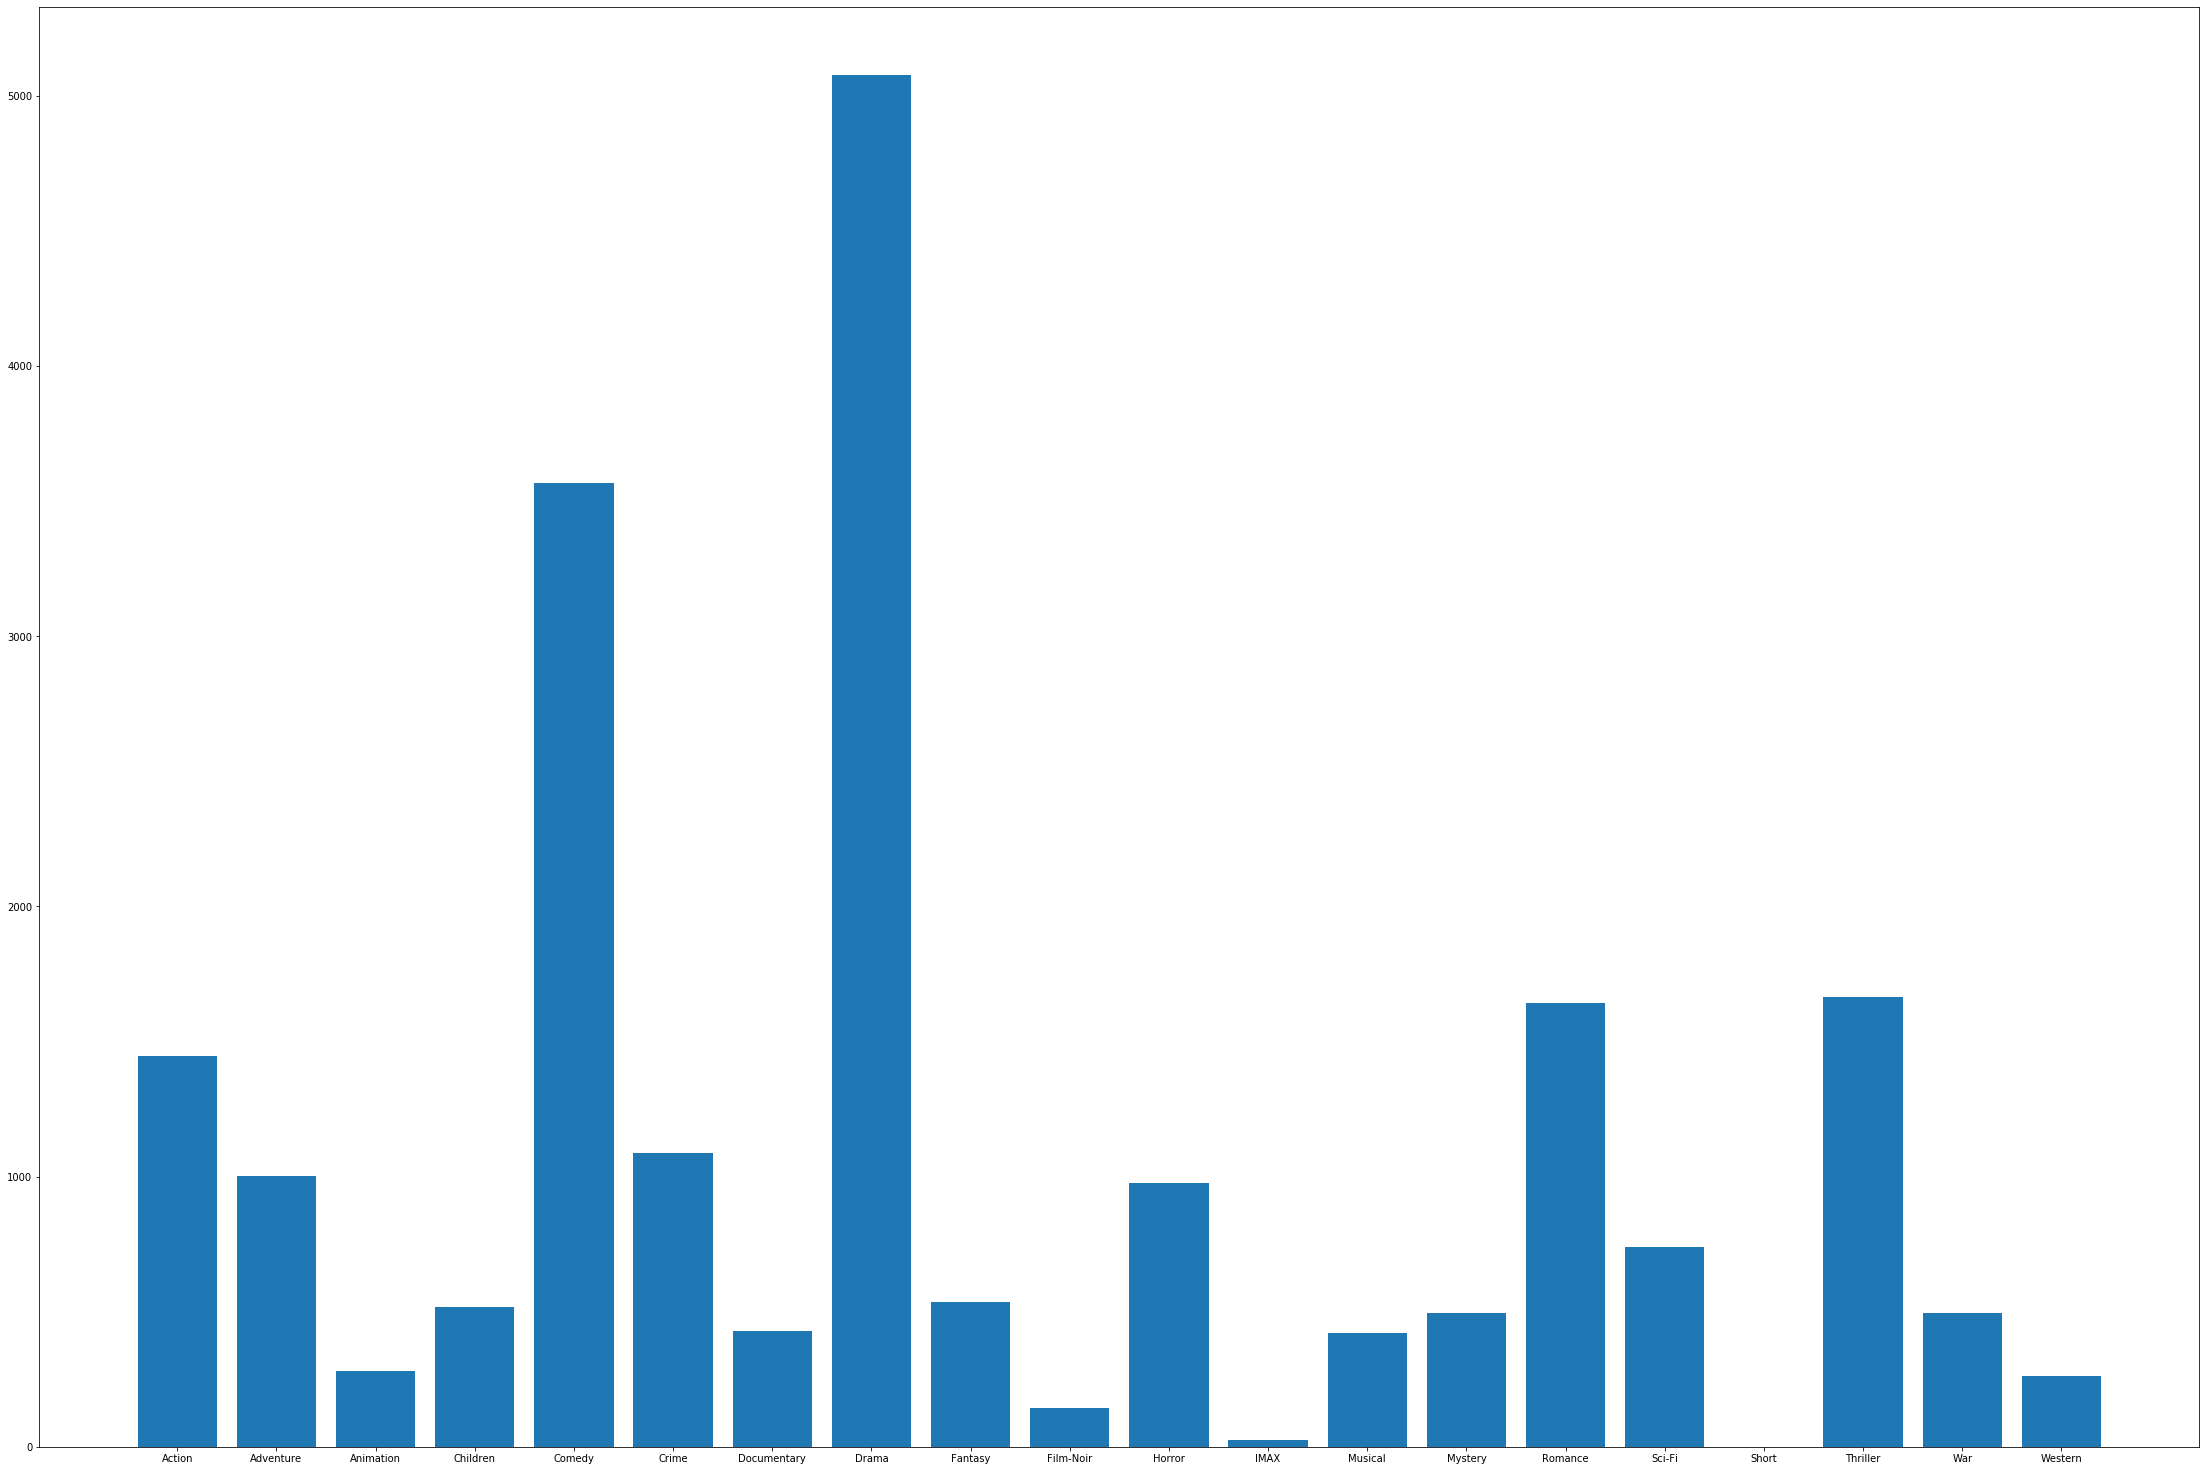

In [32]:
labels,counts=np.unique(GenreEncoding,return_counts=True)
fig = plt.figure()
ax = fig.add_axes([5,5,5,5])
ax.bar(labels,counts)
plt.show()

In [33]:
labels,counts=np.unique(GenreEncoding,return_counts=True)
array=np.array([labels,counts])
array=np.sort(array)
array

array([['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
        'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
        'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
        'Short', 'Thriller', 'War', 'Western'],
       ['1', '1003', '1086', '1445', '145', '1644', '1664', '25', '261',
        '279', '3566', '421', '430', '494', '497', '5076', '519', '535',
        '740', '978']], dtype='<U21')

**Section 1.2 Genre Matrix**

In [34]:
dataset = nltk.sent_tokenize(GenreEncodingString) 
word2count = {} 
for data in tqdm(dataset): 
    words = nltk.word_tokenize(data) 
    for word in words: 
        if word not in word2count.keys(): 
            word2count[word] = 1
        else: 
            word2count[word] += 1
freq_words = heapq.nlargest(15, word2count, key=word2count.get)
BoFGenre = [] 
for data in tqdm(ExtractedData['genre']): 
    vector = [] 
    for word in freq_words: 
        if word in nltk.word_tokenize(data): 
            vector.append(1) 
        else: 
            vector.append(0) 
    BoFGenre.append(vector) 
BoFGenre = np.asarray(BoFGenre) 

100%|█████████████████████████████████████████████████████████████████████████████| 6648/6648 [00:10<00:00, 662.41it/s]


In [36]:
DF=pd.DataFrame(BoFGenre,columns=freq_words)
DF.head()
ExtractedData=ExtractedData.reset_index()
DF=DF.reset_index()

In [37]:
GenreEncodedData=pd.merge(ExtractedData, DF, left_index=True, right_index=True)
GenreEncodedData=GenreEncodedData.drop(['index_x','index_y'],axis=1)
#doesnt work the way its supposed to.

In [58]:
GenreEncodedData.head()

,movieID,title,year,genre,Drama,Comedy,Thriller,Romance,Action,Crime,Adventure,Horror,Sci-Fi,Fantasy,Children,Mystery,War,Documentary,Musical
0,1,Toy story,1995,"Adventure, Animation, Children, Comedy, Fantasy",0,1,0,0,0,0,1,0,0,1,1,0,0,0,0
1,2,Jumanji,1995,"Adventure, Children, Fantasy",0,0,0,0,0,0,1,0,0,1,1,0,0,0,0
2,3,Grumpy Old Men,1993,"Comedy, Romance",0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,"Comedy, Drama, Romance",1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


**Section 1.3: Embedding Titles**
1. Titles are converted to 1x20 columns of embeddings
2. This allows us to extract context from the titles i.e sequels should come together
3. We will use the same logic for Tags, Actors, Directors later on
4. We will calculate Cosine Similarity and attempt to retrieve reccomendations on Genre and Titles

In [40]:
import tensorflow_hub as hub
embed = hub.load("C:\\Users\\amk_m\\Downloads\\tf2-preview_gnews-swivel-20dim_1")

In [42]:
EmbeddingTitles=embed(GenreEncodedData['title']).numpy()
names=["topic_F"+str(x) for x in range(20)]
print(names)
EmbeddedTitles=pd.DataFrame(EmbeddingTitles,columns=names)

['topic_F0', 'topic_F1', 'topic_F2', 'topic_F3', 'topic_F4', 'topic_F5', 'topic_F6', 'topic_F7', 'topic_F8', 'topic_F9', 'topic_F10', 'topic_F11', 'topic_F12', 'topic_F13', 'topic_F14', 'topic_F15', 'topic_F16', 'topic_F17', 'topic_F18', 'topic_F19']


In [ ]:
TitleGenreEncodings=pd.concat([GenreEncodedData,EmbeddedTitles],axis=1)
#TitleGenreEncodings=TitleGenreEncodings.drop(['index_x','index_y'],axis=1)

In [61]:
#Titles Embeddings via Universal Sentence Encoder and Genre 1-0 values 
TitleGenreEncodings.head()

,movieID,title,year,genre,Drama,Comedy,Thriller,Romance,Action,Crime,...,topic_F10,topic_F11,topic_F12,topic_F13,topic_F14,topic_F15,topic_F16,topic_F17,topic_F18,topic_F19
0,1,Toy story,1995,"Adventure, Animation, Children, Comedy, Fantasy",0,1,0,0,0,0,...,-1.391694,-0.799809,0.115686,-0.128886,0.118368,-0.812238,-1.202401,0.807139,0.170525,-0.211800
1,2,Jumanji,1995,"Adventure, Children, Fantasy",0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,Grumpy Old Men,1993,"Comedy, Romance",0,1,0,1,0,0,...,-0.897274,-0.604493,0.518706,-0.408605,-0.069823,-0.959486,-1.041266,0.863840,-0.060412,0.575644
3,4,Waiting to Exhale,1995,"Comedy, Drama, Romance",1,1,0,1,0,0,...,-0.180029,-0.041831,-0.074353,0.054048,-0.216928,0.096300,0.588923,-0.215821,-0.093493,0.001815
4,5,Father of the Bride Part II,1995,Comedy,0,1,0,0,0,0,...,-0.608391,-0.679735,0.414188,-0.200275,0.236952,-0.800664,-0.994438,0.609718,0.150760,0.433787


In [64]:
TitleGenreEncodings.to_csv('ReccomendationSystemTask.csv',index=False)

**The Similarity Matrix based on Genre and Title**
1. Lacks an evaluation metric as of yet
2. Through a user study that does not represent the population space, we have recieved a good approval rate (People have either already watched the movies reccomended, and/or understand why these reccomendations were made)
3. In our first run, dataset was 10719 movies huge

In [65]:
import numpy as np; import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [66]:
TitleGenreEncodings.columns

Index(['movieID', 'title', 'year', 'genre', 'Drama', 'Comedy', 'Thriller',
       'Romance', 'Action', 'Crime', 'Adventure', 'Horror', 'Sci-Fi',
       'Fantasy', 'Children', 'Mystery', 'War', 'Documentary', 'Musical',
       'topic_F0', 'topic_F1', 'topic_F2', 'topic_F3', 'topic_F4', 'topic_F5',
       'topic_F6', 'topic_F7', 'topic_F8', 'topic_F9', 'topic_F10',
       'topic_F11', 'topic_F12', 'topic_F13', 'topic_F14', 'topic_F15',
       'topic_F16', 'topic_F17', 'topic_F18', 'topic_F19'],
      dtype='object')

In [67]:
similarity = cosine_similarity(TitleGenreEncodings[['year', 'Drama', 'Comedy', 'Thriller',
       'Romance', 'Action', 'Crime', 'Adventure', 'Horror', 'Sci-Fi',
       'Fantasy', 'Children', 'Mystery', 'War', 'Documentary', 'Musical',
       'topic_F0', 'topic_F1', 'topic_F2', 'topic_F3', 'topic_F4', 'topic_F5',
       'topic_F6', 'topic_F7', 'topic_F8', 'topic_F9', 'topic_F10',
       'topic_F11', 'topic_F12', 'topic_F13', 'topic_F14', 'topic_F15',
       'topic_F16', 'topic_F17', 'topic_F18', 'topic_F19']])
similaritywithgenre=cosine_similarity(TitleGenreEncodings[['year', 'Drama', 'Comedy', 'Thriller',
       'Romance', 'Action', 'Crime', 'Adventure', 'Horror', 'Sci-Fi',
       'Fantasy', 'Children', 'Mystery', 'War', 'Documentary', 'Musical']])
#similarity['index_col'] = similarity.index

In [68]:
similaritywithgenre[1]

array([0.99999987, 1.        , 0.99999937, ..., 0.99999975, 0.99999922,
       0.99999938])

In [69]:
Top_n = 10
similarity[0].argsort()[-Top_n:][::-1]

array([   0, 1490, 2418, 1785, 3226,  759, 6645, 5251, 1709, 3566],
      dtype=int64)

In [70]:
title = "Toy story" 
movie_id = TitleGenreEncodings[TitleGenreEncodings["title"]==title]["movieID"].values[0]
print(movie_id)

1


In [71]:
similarity[0].argsort()[-Top_n:][::-1]

array([   0, 1490, 2418, 1785, 3226,  759, 6645, 5251, 1709, 3566],
      dtype=int64)

In [72]:
for index in similarity[0].argsort()[-Top_n:][::-1]:
    print(TitleGenreEncodings['title'].iloc[[index]])

0    Toy story
Name: title, dtype: object
1490    Blackbeard's Ghost
Name: title, dtype: object
2418    We're Back! A Dinosaur's Story
Name: title, dtype: object
1785    The Garbage Pail Kids Movie
Name: title, dtype: object
3226    The Wizard
Name: title, dtype: object
759    The Love Bug
Name: title, dtype: object
6645    Bedtime Stories
Name: title, dtype: object
5251    The SpongeBob SquarePants Movie
Name: title, dtype: object
1709    A Bug's Life
Name: title, dtype: object
3566    Stir Crazy
Name: title, dtype: object


**Realization:**<br>
1. We can see from the reccomendations that these are all "Genre-Induced" movies 
2. We should add more flavor to our suggestions as Toy story can retrieve a wider array of results
3. Retrieving back the same movie might act as a hint that the system is indeed working w.r.t distances
4. Evaluation Metric: Qualitative -> User Satisfaction

**Section 1.4: The Next Step**
1. Include tags in the mix in the same way as Titles i.e Embeddings
2. Calculate Cosine Similarity 
3. Retrieve Reccomendations

**Fun Fact: Inception Model does intermediate predictions to see if it's on the right track too!**

In [73]:
tagtoid=pd.merge(movie_tags[movie_tags['tagWeight']>1], tags, left_on='tagID',right_on='id')
tagtoid.drop(['id','tagWeight','tagID'],axis=1,inplace=True)
tagtoid.head()

,movieID,value
0,1,time travel
1,2,time travel
2,32,time travel
3,316,time travel
4,379,time travel


In [74]:
moviesandtags = tagtoid.groupby(['movieID'])['value'].apply(', '.join).reset_index()
moviesandtags.head()

,movieID,value
0,1,"time travel, tim allen, comedy, pixar, tom han..."
1,2,"time travel, animals, fantasy, game, robin wil..."
2,3,old
3,5,"family, wedding, pregnancy, childhood classics"
4,6,"too long, cant remember, recommendz top pick"


In [75]:
TagEmbeddings=embed(moviesandtags['value']).numpy()
names=["Tag_F"+str(x) for x in range(20)]
print(names)
TagExtractedData=pd.DataFrame(TagEmbeddings,columns=names)
TagExtractedData.head()

['Tag_F0', 'Tag_F1', 'Tag_F2', 'Tag_F3', 'Tag_F4', 'Tag_F5', 'Tag_F6', 'Tag_F7', 'Tag_F8', 'Tag_F9', 'Tag_F10', 'Tag_F11', 'Tag_F12', 'Tag_F13', 'Tag_F14', 'Tag_F15', 'Tag_F16', 'Tag_F17', 'Tag_F18', 'Tag_F19']


,Tag_F0,Tag_F1,Tag_F2,Tag_F3,Tag_F4,Tag_F5,Tag_F6,Tag_F7,Tag_F8,Tag_F9,Tag_F10,Tag_F11,Tag_F12,Tag_F13,Tag_F14,Tag_F15,Tag_F16,Tag_F17,Tag_F18,Tag_F19
0,2.312752,-0.989468,1.589768,-1.281532,-1.910704,0.796300,-0.003591,-0.998706,1.406521,-1.957082,-2.305140,1.395004,-2.442963,0.191763,-1.348063,-1.315639,-0.387860,0.767467,-0.641286,-0.789096
1,-0.062346,-0.810401,0.826755,-0.839619,-1.097751,-0.621831,0.295618,-0.719280,-0.783297,-0.175457,-1.305755,1.597886,-0.426935,0.531539,-1.583068,0.790853,1.668663,-0.273516,-1.036308,0.179430
2,0.430629,-0.688265,-0.656174,-0.665727,-0.374031,-0.431358,-0.325455,0.029263,0.655504,-0.298397,-0.430264,0.918680,-0.669077,-0.373421,-1.102863,0.264218,-0.688483,-0.140395,-0.196410,0.008075
3,0.776832,-0.550043,0.194645,-1.342958,0.245670,0.752209,-0.917581,1.287840,2.572019,-0.306152,-1.888412,0.467941,-1.613994,-0.352356,-2.164545,-1.088279,0.236017,-1.008116,-0.895948,-0.566081
4,0.148579,-1.191658,-0.130787,0.049383,-2.072951,-0.534014,-1.227999,0.463436,0.273136,-0.119534,-1.022909,0.657264,0.741594,0.132725,-1.462465,0.829166,2.123933,-0.633606,-1.581831,-0.732403


In [76]:
TagExtractedData.shape

(2963, 20)

In [77]:
TagEmbeddings.shape

(2963, 20)

In [78]:
TagEmbedDF=pd.concat([moviesandtags,TagExtractedData],axis=1)
TagEmbedDF.head()

,movieID,value,Tag_F0,Tag_F1,Tag_F2,Tag_F3,Tag_F4,Tag_F5,Tag_F6,Tag_F7,...,Tag_F10,Tag_F11,Tag_F12,Tag_F13,Tag_F14,Tag_F15,Tag_F16,Tag_F17,Tag_F18,Tag_F19
0,1,"time travel, tim allen, comedy, pixar, tom han...",2.312752,-0.989468,1.589768,-1.281532,-1.910704,0.796300,-0.003591,-0.998706,...,-2.305140,1.395004,-2.442963,0.191763,-1.348063,-1.315639,-0.387860,0.767467,-0.641286,-0.789096
1,2,"time travel, animals, fantasy, game, robin wil...",-0.062346,-0.810401,0.826755,-0.839619,-1.097751,-0.621831,0.295618,-0.719280,...,-1.305755,1.597886,-0.426935,0.531539,-1.583068,0.790853,1.668663,-0.273516,-1.036308,0.179430
2,3,old,0.430629,-0.688265,-0.656174,-0.665727,-0.374031,-0.431358,-0.325455,0.029263,...,-0.430264,0.918680,-0.669077,-0.373421,-1.102863,0.264218,-0.688483,-0.140395,-0.196410,0.008075
3,5,"family, wedding, pregnancy, childhood classics",0.776832,-0.550043,0.194645,-1.342958,0.245670,0.752209,-0.917581,1.287840,...,-1.888412,0.467941,-1.613994,-0.352356,-2.164545,-1.088279,0.236017,-1.008116,-0.895948,-0.566081
4,6,"too long, cant remember, recommendz top pick",0.148579,-1.191658,-0.130787,0.049383,-2.072951,-0.534014,-1.227999,0.463436,...,-1.022909,0.657264,0.741594,0.132725,-1.462465,0.829166,2.123933,-0.633606,-1.581831,-0.732403


In [79]:
boolean = TitleGenreEncodings['title'].duplicated().any()
boolean

False

In [82]:
TagEmbedDF.head()

,movieID,value,Tag_F0,Tag_F1,Tag_F2,Tag_F3,Tag_F4,Tag_F5,Tag_F6,Tag_F7,...,Tag_F10,Tag_F11,Tag_F12,Tag_F13,Tag_F14,Tag_F15,Tag_F16,Tag_F17,Tag_F18,Tag_F19
0,1,"time travel, tim allen, comedy, pixar, tom han...",2.312752,-0.989468,1.589768,-1.281532,-1.910704,0.796300,-0.003591,-0.998706,...,-2.305140,1.395004,-2.442963,0.191763,-1.348063,-1.315639,-0.387860,0.767467,-0.641286,-0.789096
1,2,"time travel, animals, fantasy, game, robin wil...",-0.062346,-0.810401,0.826755,-0.839619,-1.097751,-0.621831,0.295618,-0.719280,...,-1.305755,1.597886,-0.426935,0.531539,-1.583068,0.790853,1.668663,-0.273516,-1.036308,0.179430
2,3,old,0.430629,-0.688265,-0.656174,-0.665727,-0.374031,-0.431358,-0.325455,0.029263,...,-0.430264,0.918680,-0.669077,-0.373421,-1.102863,0.264218,-0.688483,-0.140395,-0.196410,0.008075
3,5,"family, wedding, pregnancy, childhood classics",0.776832,-0.550043,0.194645,-1.342958,0.245670,0.752209,-0.917581,1.287840,...,-1.888412,0.467941,-1.613994,-0.352356,-2.164545,-1.088279,0.236017,-1.008116,-0.895948,-0.566081
4,6,"too long, cant remember, recommendz top pick",0.148579,-1.191658,-0.130787,0.049383,-2.072951,-0.534014,-1.227999,0.463436,...,-1.022909,0.657264,0.741594,0.132725,-1.462465,0.829166,2.123933,-0.633606,-1.581831,-0.732403


In [90]:
TitleGenreTagsEncoding=pd.merge(TitleGenreEncodings, TagEmbedDF, on='movieID',how='left')
#TitleGenreTagsEncoding.to_csv("Test.csv",index=False)

In [93]:
#as join is left-based, our tag embeds arent really present for all movies(a hint at popularity being a factor), we replace:
TitleGenreTagsEncoding = TitleGenreTagsEncoding.replace(np.nan, 0)

In [96]:
TitleGenreTagsEncoding.tail()

,movieID,title,year,genre,Drama,Comedy,Thriller,Romance,Action,Crime,...,Tag_F10,Tag_F11,Tag_F12,Tag_F13,Tag_F14,Tag_F15,Tag_F16,Tag_F17,Tag_F18,Tag_F19
6643,64993,Byôsoku 5 senchimêtoru,2007,"Animation, Drama, Romance",1,0,0,1,0,0,...,-0.711675,0.266793,-0.783149,-0.00431,-0.493212,-0.535885,-1.059188,0.381155,-0.002112,0.414874
6644,65037,Ben X,2007,Drama,1,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6645,65088,Bedtime Stories,2008,"Adventure, Children, Comedy",0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6646,65091,Manhattan Melodrama,1934,"Crime, Drama, Romance",1,0,0,1,0,1,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6647,65126,Choke,2008,"Comedy, Drama",1,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [97]:
TitleGenreTagsEncoding.columns

Index(['movieID', 'title', 'year', 'genre', 'Drama', 'Comedy', 'Thriller',
       'Romance', 'Action', 'Crime', 'Adventure', 'Horror', 'Sci-Fi',
       'Fantasy', 'Children', 'Mystery', 'War', 'Documentary', 'Musical',
       'topic_F0', 'topic_F1', 'topic_F2', 'topic_F3', 'topic_F4', 'topic_F5',
       'topic_F6', 'topic_F7', 'topic_F8', 'topic_F9', 'topic_F10',
       'topic_F11', 'topic_F12', 'topic_F13', 'topic_F14', 'topic_F15',
       'topic_F16', 'topic_F17', 'topic_F18', 'topic_F19', 'value', 'Tag_F0',
       'Tag_F1', 'Tag_F2', 'Tag_F3', 'Tag_F4', 'Tag_F5', 'Tag_F6', 'Tag_F7',
       'Tag_F8', 'Tag_F9', 'Tag_F10', 'Tag_F11', 'Tag_F12', 'Tag_F13',
       'Tag_F14', 'Tag_F15', 'Tag_F16', 'Tag_F17', 'Tag_F18', 'Tag_F19'],
      dtype='object')

**Cosine Similarity with respect to Tags, Genres, and Titles**

In [98]:
similarity = cosine_similarity(TitleGenreTagsEncoding[['year', 'Drama', 'Comedy', 'Thriller',
       'Romance', 'Action', 'Crime', 'Adventure', 'Horror', 'Sci-Fi',
       'Fantasy', 'Children', 'Mystery', 'War', 'Documentary', 'Musical',
       'topic_F0', 'topic_F1', 'topic_F2', 'topic_F3', 'topic_F4', 'topic_F5',
       'topic_F6', 'topic_F7', 'topic_F8', 'topic_F9', 'topic_F10',
       'topic_F11', 'topic_F12', 'topic_F13', 'topic_F14', 'topic_F15',
       'topic_F16', 'topic_F17', 'topic_F18', 'topic_F19', 'Tag_F0',
       'Tag_F1', 'Tag_F2', 'Tag_F3', 'Tag_F4', 'Tag_F5', 'Tag_F6', 'Tag_F7',
       'Tag_F8', 'Tag_F9', 'Tag_F10', 'Tag_F11', 'Tag_F12', 'Tag_F13',
       'Tag_F14', 'Tag_F15', 'Tag_F16', 'Tag_F17', 'Tag_F18', 'Tag_F19']])
#similarity['index_col'] = similarity.index
similaritywithGenreTags=cosine_similarity(TitleGenreTagsEncoding[['year', 'Drama', 'Comedy', 'Thriller',
       'Romance', 'Action', 'Crime', 'Adventure', 'Horror', 'Sci-Fi',
       'Fantasy', 'Children', 'Mystery', 'War', 'Documentary', 'Musical', 'Tag_F0',
       'Tag_F1', 'Tag_F2', 'Tag_F3', 'Tag_F4', 'Tag_F5', 'Tag_F6', 'Tag_F7',
       'Tag_F8', 'Tag_F9', 'Tag_F10', 'Tag_F11', 'Tag_F12', 'Tag_F13',
       'Tag_F14', 'Tag_F15', 'Tag_F16', 'Tag_F17', 'Tag_F18', 'Tag_F19']])

In [99]:
similarity[0]

array([1.        , 0.99999388, 0.99999437, ..., 0.99999421, 0.99999167,
       0.99999265])

In [100]:
Top_n = 10
similarity[0].argsort()[-Top_n:][::-1]
title = "Toy story" 
movie_id = TitleGenreTagsEncoding[TitleGenreTagsEncoding["title"]==title]["movieID"].values[0]
print(movie_id)
for index in similarity[0].argsort()[-Top_n:][::-1]:
    print(TitleGenreTagsEncoding['title'].iloc[[index]])

1
0    Toy story
Name: title, dtype: object
5759    Wallace & Gromit in The Curse of the Were-Rabbit
Name: title, dtype: object
1542    The Lord of the Rings: The Return of the King
Name: title, dtype: object
6235    The Simpsons Movie
Name: title, dtype: object
2026    A Christmas Story
Name: title, dtype: object
1709    A Bug's Life
Name: title, dtype: object
474    The Nightmare Before Christmas
Name: title, dtype: object
503    Beauty and the Beast
Name: title, dtype: object
129    Batman Forever
Name: title, dtype: object
5674    Batman Begins
Name: title, dtype: object


**Realization:**<br>
1. Now, more factors have definetly come into play
2. More Popular titles coming together because 0 for less famous title pushes them away
3. As acquired with domain knowledge, I have watched 90% of movies suggested here w.r.t Toy Story and love this!
4. Suggestions have been borrowed from friends and they prefer this over the previous one already! 

**Section 1.5 Content Based Movie Reccomendations: with Metadeta**
1. Actor, Director, Country **->** merged with Titles, Genres, Tags 
2. Countries: USA **-** Not USA matrix
3. Actor, Director **->** embeddings
4. Cosine Similarity 
5. Update: With and Without Title Embeddings

In [101]:
#Filter out the actors based on their apperance rank
df=movie_actors[movie_actors['ranking']<=1]
df['actorName'].unique().shape
df.head()

,movieID,actorID,actorName,ranking
22,1,tom_hanks,Tom Hanks,1
41,2,robin_williams,Robin Williams,1
49,3,jack_lemmon,Jack Lemmon,1
76,4,whitney_houston,Whitney Houston,1
100,5,steve_martin,Steve Martin,1


In [107]:
#join movies and actors
movie_actors['actorName']=movie_actors['actorName'].astype(str)
moviesandactors = df.groupby(['movieID'])['actorName'].apply(', '.join).reset_index()
moviesandactors.head()

,movieID,actorName
0,1,Tom Hanks
1,2,Robin Williams
2,3,Jack Lemmon
3,4,Whitney Houston
4,5,Steve Martin


In [108]:
movie_directors['directorName']=movie_directors['directorName'].astype(str)
moviesanddirectors = movie_directors.groupby(['movieID'])['directorName'].apply(', '.join).reset_index()
moviesanddirectors.head()

,movieID,directorName
0,1,John Lasseter
1,2,Joe Johnston
2,3,Donald Petrie
3,4,Forest Whitaker
4,5,Charles Shyer


In [125]:
actorsanddirectors=pd.merge(moviesandactors,moviesanddirectors,on='movieID',how='inner')

In [128]:
actorsanddirectors['movieID'].shape

(10134,)

In [129]:
actorsanddirectors[actorsanddirectors['actorName']=='Tom Hanks']

,movieID,actorName,directorName
0,1,Tom Hanks,John Lasseter
141,150,Tom Hanks,Ron Howard
343,356,Tom Hanks,Robert Zemeckis
487,508,Tom Hanks,Jonathan Demme
518,539,Tom Hanks,Nora Ephron
1618,1827,Tom Hanks,Penny Marshall
1812,2028,Tom Hanks,Steven Spielberg
1856,2072,Tom Hanks,Joe Dante
1884,2100,Tom Hanks,Ron Howard
2189,2418,Tom Hanks,Garry Marshall


**This goes without saying Tom Hanks has starred in multiple movies alongside multiple directors and might be some users favorite**

In [131]:
print(movie_countries['country'].isnull().values.any())
movie_countries['country'].isnull().sum()
movie_countries=movie_countries.dropna()

False


In [134]:
movie_countries["country"]= movie_countries["country"].replace("USA", 1)
movie_countries["country"] = movie_countries["country"].mask(movie_countries["country"] !=1, 0)
#movie_countries.to_csv("TestMovieData.csv")

In [135]:
#movie_countries.apply(LabelEncoder().fit_transform(movie_countries['country']))
#movie_countries['country'] =LabelEncoder().fit_transform(movie_countries['country'])

In [136]:
movie_countries['country'].describe()

count     10189
unique        2
top           1
freq       6831
Name: country, dtype: int64

**Here, we are breaking down the countries data to USA-NOTUSA as nearly 70% of movies are from USA**

In [137]:
movie_countriesUSA=movie_countries.copy(deep=True)
movie_countriesNUSA=movie_countries.copy(deep=True)
movie_countriesUSA.columns=['movieID','USA']
movie_countriesNUSA.columns=['movieID','NUSA']
movie_countriesNUSA['NUSA'] = movie_countriesNUSA['NUSA'].replace({0:1, 1:0})
#movie_countriesNUSA
movie_countriesFinale=pd.merge(movie_countriesUSA,movie_countriesNUSA,on='movieID')
movie_countriesFinale.tail()

,movieID,USA,NUSA
10184,65088,1,0
10185,65091,1,0
10186,65126,1,0
10187,65130,1,0
10188,65133,0,1


In [139]:
actorsdirectorscountries=pd.merge(actorsanddirectors,movie_countriesFinale,on='movieID')
actorsdirectorscountries.head()

,movieID,actorName,directorName,USA,NUSA
0,1,Tom Hanks,John Lasseter,1,0
1,2,Robin Williams,Joe Johnston,1,0
2,3,Jack Lemmon,Donald Petrie,1,0
3,4,Whitney Houston,Forest Whitaker,1,0
4,5,Steve Martin,Charles Shyer,1,0


In [141]:
actorembeds=embed(actorsanddirectors['actorName']).numpy()
names=["actors_F"+str(x) for x in range(20)]
print(names)
actorExtractedData=pd.DataFrame(actorembeds,columns=names)
actorExtractedData.head()

['actors_F0', 'actors_F1', 'actors_F2', 'actors_F3', 'actors_F4', 'actors_F5', 'actors_F6', 'actors_F7', 'actors_F8', 'actors_F9', 'actors_F10', 'actors_F11', 'actors_F12', 'actors_F13', 'actors_F14', 'actors_F15', 'actors_F16', 'actors_F17', 'actors_F18', 'actors_F19']


,actors_F0,actors_F1,actors_F2,actors_F3,actors_F4,actors_F5,actors_F6,actors_F7,actors_F8,actors_F9,actors_F10,actors_F11,actors_F12,actors_F13,actors_F14,actors_F15,actors_F16,actors_F17,actors_F18,actors_F19
0,-0.333418,-1.779091,-0.791577,-1.531474,-0.559442,1.256425,0.351360,1.007785,1.632603,0.742198,-1.286969,-0.999410,0.823705,-1.223432,0.703854,-0.451580,-0.522701,1.188622,0.308879,0.418487
1,-0.452748,-1.825097,-1.065131,-1.501005,-0.056070,1.312636,0.039013,1.149850,1.328850,0.688528,-1.196976,-0.594049,1.343878,-0.937165,0.532715,-0.023929,-0.391274,0.367733,0.447520,0.602501
2,-0.238248,-0.835818,-0.619902,-0.712091,-0.254227,0.812728,-0.021525,0.532269,0.944292,0.483457,-0.566314,-0.027771,0.682769,-0.451713,0.286310,-0.068402,-0.179913,0.461644,0.268155,0.312862
3,-0.309986,-1.368361,-1.024832,-1.427086,0.640924,1.010270,0.199718,-0.213346,0.198137,0.806633,-1.763526,-0.104799,1.243923,-0.252106,-0.023417,0.112558,-0.930885,0.633923,0.499440,0.959052
4,-0.473044,-1.874066,-0.490820,-1.567631,0.331746,1.166213,0.413818,0.737748,1.598423,1.162301,-0.782808,-0.529417,1.301883,-0.975605,1.191963,-0.206265,-0.197906,1.027958,0.721508,0.806618


In [142]:
directorembeds=embed(actorsanddirectors['directorName']).numpy()
names=["directors_F"+str(x) for x in range(20)]
print(names)
directorExtractedData=pd.DataFrame(directorembeds,columns=names)
directorExtractedData.head()

['directors_F0', 'directors_F1', 'directors_F2', 'directors_F3', 'directors_F4', 'directors_F5', 'directors_F6', 'directors_F7', 'directors_F8', 'directors_F9', 'directors_F10', 'directors_F11', 'directors_F12', 'directors_F13', 'directors_F14', 'directors_F15', 'directors_F16', 'directors_F17', 'directors_F18', 'directors_F19']


,directors_F0,directors_F1,directors_F2,directors_F3,directors_F4,directors_F5,directors_F6,directors_F7,directors_F8,directors_F9,directors_F10,directors_F11,directors_F12,directors_F13,directors_F14,directors_F15,directors_F16,directors_F17,directors_F18,directors_F19
0,-0.252181,-0.927361,-0.231777,-0.912130,0.491651,0.575678,0.241689,0.588149,0.929212,0.433252,-0.460064,-0.590464,0.607007,-0.687870,0.456539,-0.032492,-0.275420,0.655479,0.474778,0.476021
1,-0.569218,-1.734962,-0.950825,-1.385349,0.299962,1.170124,0.415418,1.246468,1.056857,1.239762,-1.058670,-0.525210,1.422491,-1.090790,0.839541,0.237497,-0.201687,1.191358,0.624746,0.626180
2,-0.803633,-0.218671,0.856281,-0.667001,0.490485,0.219580,0.444163,0.654473,0.823934,0.569644,0.225105,-0.653097,0.581999,-0.285077,0.914893,0.175597,0.381039,-0.408570,-0.618443,0.390962
3,-0.346459,0.382251,-0.218554,-0.576592,0.749572,0.149732,0.199274,0.004454,-0.746907,0.819507,-0.559638,-0.032697,0.288008,-0.119868,0.228856,0.073922,-0.703598,0.887784,0.457597,0.433813
4,-0.363227,-0.742808,-0.522909,-0.814757,0.765352,0.604321,-0.022693,0.456844,0.883219,0.565462,-0.327141,-0.493852,0.371466,-0.576322,0.274291,-0.325437,-0.502540,0.383853,0.547358,0.301073


In [144]:
ActorEmbedDF=pd.concat([actorsanddirectors,actorExtractedData],axis=1)
ActorEmbedDF.head()

,movieID,actorName,directorName,actors_F0,actors_F1,actors_F2,actors_F3,actors_F4,actors_F5,actors_F6,...,actors_F10,actors_F11,actors_F12,actors_F13,actors_F14,actors_F15,actors_F16,actors_F17,actors_F18,actors_F19
0,1,Tom Hanks,John Lasseter,-0.333418,-1.779091,-0.791577,-1.531474,-0.559442,1.256425,0.351360,...,-1.286969,-0.999410,0.823705,-1.223432,0.703854,-0.451580,-0.522701,1.188622,0.308879,0.418487
1,2,Robin Williams,Joe Johnston,-0.452748,-1.825097,-1.065131,-1.501005,-0.056070,1.312636,0.039013,...,-1.196976,-0.594049,1.343878,-0.937165,0.532715,-0.023929,-0.391274,0.367733,0.447520,0.602501
2,3,Jack Lemmon,Donald Petrie,-0.238248,-0.835818,-0.619902,-0.712091,-0.254227,0.812728,-0.021525,...,-0.566314,-0.027771,0.682769,-0.451713,0.286310,-0.068402,-0.179913,0.461644,0.268155,0.312862
3,4,Whitney Houston,Forest Whitaker,-0.309986,-1.368361,-1.024832,-1.427086,0.640924,1.010270,0.199718,...,-1.763526,-0.104799,1.243923,-0.252106,-0.023417,0.112558,-0.930885,0.633923,0.499440,0.959052
4,5,Steve Martin,Charles Shyer,-0.473044,-1.874066,-0.490820,-1.567631,0.331746,1.166213,0.413818,...,-0.782808,-0.529417,1.301883,-0.975605,1.191963,-0.206265,-0.197906,1.027958,0.721508,0.806618


In [149]:
DirectorEmbedDF=pd.concat([actorsanddirectors,directorExtractedData],axis=1)
DirectorEmbedDF.head()

,movieID,actorName,directorName,directors_F0,directors_F1,directors_F2,directors_F3,directors_F4,directors_F5,directors_F6,...,directors_F10,directors_F11,directors_F12,directors_F13,directors_F14,directors_F15,directors_F16,directors_F17,directors_F18,directors_F19
0,1,Tom Hanks,John Lasseter,-0.252181,-0.927361,-0.231777,-0.912130,0.491651,0.575678,0.241689,...,-0.460064,-0.590464,0.607007,-0.687870,0.456539,-0.032492,-0.275420,0.655479,0.474778,0.476021
1,2,Robin Williams,Joe Johnston,-0.569218,-1.734962,-0.950825,-1.385349,0.299962,1.170124,0.415418,...,-1.058670,-0.525210,1.422491,-1.090790,0.839541,0.237497,-0.201687,1.191358,0.624746,0.626180
2,3,Jack Lemmon,Donald Petrie,-0.803633,-0.218671,0.856281,-0.667001,0.490485,0.219580,0.444163,...,0.225105,-0.653097,0.581999,-0.285077,0.914893,0.175597,0.381039,-0.408570,-0.618443,0.390962
3,4,Whitney Houston,Forest Whitaker,-0.346459,0.382251,-0.218554,-0.576592,0.749572,0.149732,0.199274,...,-0.559638,-0.032697,0.288008,-0.119868,0.228856,0.073922,-0.703598,0.887784,0.457597,0.433813
4,5,Steve Martin,Charles Shyer,-0.363227,-0.742808,-0.522909,-0.814757,0.765352,0.604321,-0.022693,...,-0.327141,-0.493852,0.371466,-0.576322,0.274291,-0.325437,-0.502540,0.383853,0.547358,0.301073


In [151]:
ActorDirectorEmbeds=pd.merge(ActorEmbedDF, DirectorEmbedDF, on='movieID')
TitleGenreActorDirectorTag=pd.merge(ActorDirectorEmbeds,TitleGenreTagsEncoding,on='movieID')
TitleGenreActorDirectorTag.head()

,movieID,actorName_x,directorName_x,actors_F0,actors_F1,actors_F2,actors_F3,actors_F4,actors_F5,actors_F6,...,Tag_F10,Tag_F11,Tag_F12,Tag_F13,Tag_F14,Tag_F15,Tag_F16,Tag_F17,Tag_F18,Tag_F19
0,1,Tom Hanks,John Lasseter,-0.333418,-1.779091,-0.791577,-1.531474,-0.559442,1.256425,0.351360,...,-2.305140,1.395004,-2.442963,0.191763,-1.348063,-1.315639,-0.387860,0.767467,-0.641286,-0.789096
1,2,Robin Williams,Joe Johnston,-0.452748,-1.825097,-1.065131,-1.501005,-0.056070,1.312636,0.039013,...,-1.305755,1.597886,-0.426935,0.531539,-1.583068,0.790853,1.668663,-0.273516,-1.036308,0.179430
2,3,Jack Lemmon,Donald Petrie,-0.238248,-0.835818,-0.619902,-0.712091,-0.254227,0.812728,-0.021525,...,-0.430264,0.918680,-0.669077,-0.373421,-1.102863,0.264218,-0.688483,-0.140395,-0.196410,0.008075
3,4,Whitney Houston,Forest Whitaker,-0.309986,-1.368361,-1.024832,-1.427086,0.640924,1.010270,0.199718,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,Steve Martin,Charles Shyer,-0.473044,-1.874066,-0.490820,-1.567631,0.331746,1.166213,0.413818,...,-1.888412,0.467941,-1.613994,-0.352356,-2.164545,-1.088279,0.236017,-1.008116,-0.895948,-0.566081


In [152]:
TitleGenreActorDirectorTag.shape

(6645, 104)

**Important Note: Due to default merge being inner, intersection occurs and only the titles with common details make the cut!**
1. This helps us filter out automatically
2. This haunted me for about 3 days as the final dataframe was at 2200 movies without the popularity filter!
3. The issue was in one of the merges made during tags as they were not available for all movies
4. Where it wasn't beneficial to us, I have applied left/outer joins and dealt with NaN values accordingly

In [156]:
TitleGenreActorDirectorTagCountry=pd.merge(TitleGenreActorDirectorTag,movie_countriesFinale,on='movieID')
TitleGenreActorDirectorTagCountry.head()

,movieID,actorName_x,directorName_x,actors_F0,actors_F1,actors_F2,actors_F3,actors_F4,actors_F5,actors_F6,...,Tag_F12,Tag_F13,Tag_F14,Tag_F15,Tag_F16,Tag_F17,Tag_F18,Tag_F19,USA,NUSA
0,1,Tom Hanks,John Lasseter,-0.333418,-1.779091,-0.791577,-1.531474,-0.559442,1.256425,0.351360,...,-2.442963,0.191763,-1.348063,-1.315639,-0.387860,0.767467,-0.641286,-0.789096,1,0
1,2,Robin Williams,Joe Johnston,-0.452748,-1.825097,-1.065131,-1.501005,-0.056070,1.312636,0.039013,...,-0.426935,0.531539,-1.583068,0.790853,1.668663,-0.273516,-1.036308,0.179430,1,0
2,3,Jack Lemmon,Donald Petrie,-0.238248,-0.835818,-0.619902,-0.712091,-0.254227,0.812728,-0.021525,...,-0.669077,-0.373421,-1.102863,0.264218,-0.688483,-0.140395,-0.196410,0.008075,1,0
3,4,Whitney Houston,Forest Whitaker,-0.309986,-1.368361,-1.024832,-1.427086,0.640924,1.010270,0.199718,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0
4,5,Steve Martin,Charles Shyer,-0.473044,-1.874066,-0.490820,-1.567631,0.331746,1.166213,0.413818,...,-1.613994,-0.352356,-2.164545,-1.088279,0.236017,-1.008116,-0.895948,-0.566081,1,0


In [163]:
TitleGenreActorDirectorTagCountry.shape

(6644, 106)

In [160]:
similarity1 = cosine_similarity(TitleGenreActorDirectorTagCountry[['actors_F0', 'actors_F1',
       'actors_F2', 'actors_F3', 'actors_F4', 'actors_F5', 'actors_F6',
       'actors_F7', 'actors_F8', 'actors_F9', 'actors_F10', 'actors_F11',
       'actors_F12', 'actors_F13', 'actors_F14', 'actors_F15', 'actors_F16',
       'actors_F17', 'actors_F18', 'actors_F19', 'directors_F0', 'directors_F1', 'directors_F2',
       'directors_F3', 'directors_F4', 'directors_F5', 'directors_F6',
       'directors_F7', 'directors_F8', 'directors_F9', 'directors_F10',
       'directors_F11', 'directors_F12', 'directors_F13', 'directors_F14',
       'directors_F15', 'directors_F16', 'directors_F17', 'directors_F18',
       'directors_F19', 'year', 'Drama', 'Comedy',
       'Thriller', 'Romance', 'Action', 'Crime', 'Adventure', 'Horror',
       'Sci-Fi', 'Fantasy', 'Children', 'Mystery', 'War', 'Documentary',
       'Musical', 'topic_F0', 'topic_F1', 'topic_F2', 'topic_F3', 'topic_F4',
       'topic_F5', 'topic_F6', 'topic_F7', 'topic_F8', 'topic_F9', 'topic_F10',
       'topic_F11', 'topic_F12', 'topic_F13', 'topic_F14', 'topic_F15',
       'topic_F16', 'topic_F17', 'topic_F18', 'topic_F19', 'Tag_F0',
       'Tag_F1', 'Tag_F2', 'Tag_F3', 'Tag_F4', 'Tag_F5', 'Tag_F6', 'Tag_F7',
       'Tag_F8', 'Tag_F9', 'Tag_F10', 'Tag_F11', 'Tag_F12', 'Tag_F13',
       'Tag_F14', 'Tag_F15', 'Tag_F16', 'Tag_F17', 'Tag_F18', 'Tag_F19','USA','NUSA']])

In [161]:
Top_n = 10
similarity1[0].argsort()[-Top_n:][::-1]
title = "Toy story" 
movie_id = TitleGenreActorDirectorTagCountry[TitleGenreActorDirectorTagCountry["title"]==title]["movieID"].values[0]
print(movie_id)
for index in similarity1[0].argsort()[-Top_n:][::-1]:
    print(TitleGenreActorDirectorTagCountry['title'].iloc[[index]])

1
0    Toy story
Name: title, dtype: object
1709    A Bug's Life
Name: title, dtype: object
6231    The Simpsons Movie
Name: title, dtype: object
474    The Nightmare Before Christmas
Name: title, dtype: object
933    Evil Dead II
Name: title, dtype: object
5695    Happy Endings
Name: title, dtype: object
2796    The Emperor's New Groove
Name: title, dtype: object
1553    Charlotte's Web
Name: title, dtype: object
1542    The Lord of the Rings: The Return of the King
Name: title, dtype: object
503    Beauty and the Beast
Name: title, dtype: object


**Final Note:**
1. Movies like Batman have been pushed away and more children friendly titles have come into play
2. Embeddings extract the context -> push things that belong together ever so close
3. We can filter movies out of the loop based on a popularity factor to bring forward more "good" reccomendations
4. These reccomendations when shown made more 'sense' to a few movie buff friends of mine

**Towards User-Item Based collaborative filtering we go, where the customer, you, are our priority!**

**Section 2: Collaborative Filtering** <br>

**Purpose:**
1. Effectively model the user-item relationship 
2. Evaluate the effectiveness through a quantitative measure 
3. Connect the dots 

In [164]:
user_ratedmovies_timestamps['rating'].describe()

count    855598.000000
mean          3.437945
std           1.002561
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Average User Rating: 3.5

Min User Rating: 0.5


In [166]:
userandpopularity=pd.merge(user_ratedmovies_timestamps,movie,left_on='movieID',right_on='id')
userandpopularity=userandpopularity[['userID', 'movieID', 'rating', 'timestamp','rtAudienceNumRatings']]
userandpopularity.head()


,userID,movieID,rating,timestamp,rtAudienceNumRatings
0,75,3,1.0,1162160236000,10489
1,783,3,2.0,1162488835000,10489
2,788,3,3.5,1188564581000,10489
3,1160,3,4.0,1216125522000,10489
4,1174,3,2.5,1111555400000,10489


In [167]:
userpopularitygenre=pd.merge(userandpopularity,GenreEncodedData,on='movieID')
userpopularitygenre.columns
userpopularitygenre=userpopularitygenre[['userID', 'movieID','rtAudienceNumRatings','Drama', 'Comedy', 'Thriller', 'Romance',
       'Action', 'Crime', 'Adventure', 'Horror', 'Sci-Fi', 'Fantasy',
       'Children', 'Mystery', 'War', 'Documentary', 'Musical', 'rating']]#dropping timestamp for the time being
userpopularitygenre.head()


,userID,movieID,rtAudienceNumRatings,Drama,Comedy,Thriller,Romance,Action,Crime,Adventure,Horror,Sci-Fi,Fantasy,Children,Mystery,War,Documentary,Musical,rating
0,75,3,10489,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0
1,783,3,10489,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0
2,788,3,10489,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,3.5
3,1160,3,10489,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,4.0
4,1174,3,10489,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2.5


**Section 2.1: Applying a model to predict a user's rating**<br>
1. Using Surprise Library: Apply Model, Evaluate
2. Split dataset to: Train/Test
3. Evaluation Criteria: RMSE, MAE
4. Because of many reasons, misclassification is reported on multiple papers as a signficant issue

In [168]:
reader = Reader()
algo = SVD()
data = Dataset.load_from_df(user_ratedmovies_timestamps[['userID','movieID','rating']], reader)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7684  0.7715  0.7680  0.7740  0.7691  0.7702  0.0023  
MAE (testset)     0.5818  0.5837  0.5803  0.5865  0.5827  0.5830  0.0021  
Fit time          43.27   43.74   43.86   44.37   43.79   43.81   0.35    
Test time         1.64    1.57    1.61    1.54    1.85    1.64    0.11    


{'test_rmse': array([0.76835122, 0.77153952, 0.76799514, 0.77397514, 0.76906668]),
 'test_mae': array([0.58175047, 0.58372328, 0.58030365, 0.58648295, 0.58270518]),
 'fit_time': (43.27178192138672,
  43.73742175102234,
  43.85758137702942,
  44.37079095840454,
  43.793063163757324),
 'test_time': (1.644254446029663,
  1.5735843181610107,
  1.6084952354431152,
  1.5400381088256836,
  1.8503365516662598)}

**Section 2.2 : Train-Test split**
1. We split dataset with 25% of it reserved for testing 
2. We train and measure accuracy on RMSE and MAE
3. RMSE gives us: concentration of data w.r.t best-fit line
4. MAE gives us: how big of an error can we expect

In [169]:
reader = Reader()
data = Dataset.load_from_df(user_ratedmovies_timestamps[['userID','movieID','rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

**Section 2.3: Benchmarking**
1. Benchmark will give us a list of models that work best on default
2. We will then optimize the top-3 and aggregate their rating for our predictions
3. We will use the best models for collaborative filtering
4. We will benchmark and select top-3 and optimize them for our rating predictions

**Fun Fact: Netflix competition winner used SVD and since then, they have been very popular for the job**

In [170]:
benchmark = []
# Iterate over all algorithms
reader = Reader()
data = Dataset.load_from_df(user_ratedmovies_timestamps[['userID','movieID','rating']], reader)
for algorithm in tqdm([SVD(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]):
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=5, verbose=True)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
ModelData=pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
ModelData

 12%|██████████▍                                                                        | 1/8 [03:57<27:42, 237.46s/it]

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7724  0.7722  0.7704  0.7691  0.7692  0.7707  0.0014  
MAE (testset)     0.5851  0.5849  0.5824  0.5823  0.5818  0.5833  0.0014  
Fit time          43.25   43.87   44.94   43.90   43.95   43.98   0.54    
Test time         1.75    1.62    1.77    1.62    1.69    1.69    0.07    


 25%|████████████████████▊                                                              | 2/8 [04:21<17:21, 173.51s/it]

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3779  1.3762  1.3768  1.3759  1.3775  1.3769  0.0007  
MAE (testset)     1.0981  1.0980  1.0985  1.0966  1.0985  1.0979  0.0007  
Fit time          1.13    1.44    1.51    1.50    1.62    1.44    0.16    
Test time         1.68    1.63    1.75    1.99    1.81    1.77    0.12    
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


 38%|███████████████████████████████▏                                                   | 3/8 [12:40<22:35, 271.03s/it]

Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7933  0.7889  0.7901  0.7895  0.7919  0.7907  0.0016  
MAE (testset)     0.6014  0.5986  0.5993  0.5989  0.6008  0.5998  0.0011  
Fit time          23.63   24.35   23.81   22.99   23.42   23.64   0.45    
Test time         75.17   72.60   75.86   73.21   75.04   74.37   1.25    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 50%|█████████████████████████████████████████▌                                         | 4/8 [20:08<21:36, 324.25s/it]

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8181  0.8220  0.8183  0.8181  0.8174  0.8188  0.0017  
MAE (testset)     0.6177  0.6219  0.6185  0.6179  0.6169  0.6186  0.0017  
Fit time          19.63   20.09   20.71   20.40   20.76   20.32   0.42    
Test time         64.70   68.70   67.23   69.25   68.11   67.60   1.60    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 62%|███████████████████████████████████████████████████▉                               | 5/8 [27:49<18:15, 365.10s/it]

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8056  0.8077  0.8101  0.8091  0.8069  0.8079  0.0016  
MAE (testset)     0.6154  0.6175  0.6184  0.6178  0.6161  0.6170  0.0011  
Fit time          20.10   20.01   20.92   20.44   20.43   20.38   0.32    
Test time         69.22   68.88   71.51   70.74   69.57   69.98   0.99    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [35:25<13:05, 392.57s/it]

Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8047  0.8058  0.8053  0.8041  0.8063  0.8052  0.0008  
MAE (testset)     0.6105  0.6116  0.6107  0.6114  0.6122  0.6112  0.0006  
Fit time          20.79   20.68   20.43   20.30   20.46   20.53   0.18    
Test time         69.49   68.89   68.87   69.30   69.04   69.12   0.24    
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [35:58<04:44, 284.48s/it]

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8078  0.8100  0.8127  0.8105  0.8081  0.8098  0.0018  
MAE (testset)     0.6145  0.6170  0.6190  0.6161  0.6141  0.6161  0.0018  
Fit time          3.07    3.29    3.31    3.29    3.30    3.25    0.09    
Test time         1.46    1.43    2.08    1.48    1.44    1.58    0.25    


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [38:00<00:00, 285.06s/it]

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8373  0.8389  0.8398  0.8388  0.8375  0.8385  0.0009  
MAE (testset)     0.6511  0.6526  0.6538  0.6536  0.6521  0.6526  0.0010  
Fit time          20.68   21.92   21.19   20.90   20.96   21.13   0.43    
Test time         1.69    1.72    1.74    2.36    1.63    1.83    0.27    


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.770680,0.583283,43.982725,1.690108
KNNBaseline,0.790740,0.599798,23.641201,74.373301
KNNWithZScore,0.805236,0.611247,20.531046,69.117370
KNNWithMeans,0.807878,0.617037,20.379594,69.982161
BaselineOnly,0.809805,0.616130,3.252750,1.576678
KNNBasic,0.818782,0.618583,20.317105,67.598210
CoClustering,0.838467,0.652649,21.130931,1.830551
NormalPredictor,1.376870,1.097919,1.437893,1.771484


**Section 2.4 Selected Models:**
1. SVD
2. KNNBaseline
3. KNNWithZScore

**Note: SVD will be hyperparameter-tuned and all other models will remain in their default state**

In [171]:
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005,0.001,0.01],
              'reg_all': [0.4, 0.6, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])
algo = gs.best_estimator['rmse']
algo.fit(trainset)
predictions = algo.test(testset)

0.8160323823780523
{'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.2}


In [172]:
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.8198
MAE:  0.6265


0.6264692701334962

In [173]:
algo1=KNNBaseline()
algo1.fit(trainset)
predictions1 = algo1.test(testset)
accuracy.rmse(predictions1)
accuracy.mae(predictions1)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7951
MAE:  0.6030


0.6030378688936903

In [174]:
algo2=KNNWithZScore()
algo2.fit(trainset)
predictions2 = algo2.test(testset)
accuracy.rmse(predictions2)
accuracy.mae(predictions2)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8097
MAE:  0.6147


0.6147069355241408

**Section 2.5: Performing heterogenous ensemble**
1. Using UserID and Movie ID, predict on top-3 models
2. Extract estimated score
3. Aggregate the result 

In [175]:
def EnsembleCall(UID,IID):
    predictor1=algo.predict(uid=UID,iid=IID)
    predictor2=algo1.predict(uid=UID,iid=IID)
    predictor3=algo2.predict(uid=UID,iid=IID)
    est1=predictor1.est
    est2=predictor2.est
    est3=predictor3.est
    mean=(est1+est2+est3)/3
    return mean

**Section 2.6: Reccomender as functions**<br>
<br>**Content-Based Reccomender**
1. Title to MovieID mapping
2. Index to Title mapping
3. Fetch top 10 movies based on title 
4. Display

In [176]:
TitleGenreEncodings= TitleGenreEncodings.reset_index()
titles = TitleGenreEncodings['title']
indices = pd.Series(TitleGenreEncodings.index, index=TitleGenreEncodings['title'])

In [177]:
TitleGenreActorDirectorTagCountry= TitleGenreActorDirectorTagCountry.reset_index()
titles = TitleGenreActorDirectorTagCountry['title']
indices = pd.Series(TitleGenreActorDirectorTagCountry.index, index=TitleGenreActorDirectorTagCountry['title'])

In [180]:
titles.shape ##if 2262 -> TitleGenreActorDirectorTagCountry dataframe is in play! 

(6644,)

In [181]:
def CBReccomender(title): #based on Titles, Genres, Tags, Country, Actor, and Director 
    Top_n = 10
    idx=indices[title]
    #title='Live Free or Die Hard'
    scores=similarity1[idx].argsort()[-Top_n:][::-1]
    movie_id = TitleGenreActorDirectorTagCountry[TitleGenreActorDirectorTagCountry["title"]==title]["movieID"].values[0]
    print(movie_id)
    reccomendations=[]
    for index in scores:
        reccomendations.append(TitleGenreActorDirectorTagCountry['title'].values[index])
    reccomendations.pop(0)
    return reccomendations

In [182]:
CBReccomender("Batman")

592


['Batman Begins',
 'Superman Returns',
 'Batman Returns',
 'Superman III',
 'Teenage Mutant Ninja Turtles II: The Secret of the Ooze',
 'Strange Days',
 'Shakespeare in Love',
 'Repo Man',
 'Midnight Cowboy']

**Oh Look! our Content-Based Reccomender is looking really good with the reccomendations!**
1. Look at all the relevant movie titles being together
2. Look at all the Genre-Wise hints being present in the retrieved result
3. The first movie being the same as the movie required acts as a verification that it works<br>
<br>

**Note: Other fun tests were done to note how movies like The Godfather retrieved movies with "The" in their title hinting at the fact that before embedding, we should have filtered out the stop words.**

In [183]:
CBReccomender("The Godfather")

858


['Casablanca',
 'The Treasure of the Sierra Madre',
 'The Godfather: Part II',
 'The Grapes of Wrath',
 'The Maltese Falcon',
 'The Shape of Things',
 'Lola rennt',
 'Il postino',
 'Persepolis']

**Results like Lola rennt, and other Non-USA titles show that we could have increased the influence of USA-NUSA by duplicating the columns**


With all the intermediate predictions done above and multiple similarity matrices made and stored above, tested out, this one seemed the most generalizable across many titles and was kept for display<br>
**Note: Anyone with access to the notebook can try out the many combinations w.r.t Titles-Genre, Genre-Tags, Actor-Director etc** 

<br>**Section 2.7: Hybrid Reccomender**
1. Take UserID -> Last 3 movies with respect to timestamps
2. On the titles extracted -> Apply Content-Based Reccommender from above
3. Predict User's rating via Ensembler 
4. Sort on estimates -> Display!

In [188]:
def HybridReccomender(UserID):
    UID=UserID
    user_ratedmovies_timestamps['userID']=user_ratedmovies_timestamps['userID'].astype(int)
    rslt_df = user_ratedmovies_timestamps[user_ratedmovies_timestamps['movieID'].isin(TitleGenreActorDirectorTagCountry['movieID'])] 
    #rslt_df filters out movies w.r.t to qualified movies
    movietimestamped=rslt_df[rslt_df["userID"]==UID].sort_values('timestamp')['movieID'].values[:3]
    IID=movietimestamped
    movielist=[]
    title=[]
    for i in range(3):
        #print(i)
        moviename=TitleGenreActorDirectorTagCountry[TitleGenreActorDirectorTagCountry['movieID']==IID[i]]['title'].values
        #print(moviename[i])
        title=moviename[0]
        print(title)
        movielist.extend(CBReccomender(title))
    SelectedMovies=[]
    for xyz in range(27):
        x=(TitleGenreActorDirectorTagCountry[TitleGenreActorDirectorTagCountry["title"]==movielist[xyz]]["movieID"].values[0])
        SelectedMovies.append(x)
    SelectedMovies=[filler for filler in SelectedMovies if filler not in IID] #filter to remove movie titles that CB built upon
    SelectedMovies=[x for x in SelectedMovies if x not in IID]
    #SelectedMovies
    movieuser=list(zip(SelectedMovies,movielist))
    #movieuser
    #movieuser[1][0] # gives movieID
    #movieuser[0][1] # gives movie title w.r.t movieID
    testframe=pd.DataFrame(movieuser,columns=['movieID','Title'])
    Length=len(testframe['movieID'])
    #est=[]
    for x in range(Length):
        loopover=testframe.at[x,'movieID']
        est=EnsembleCall(UID,loopover)
        #print(testframe.loc[loopover])
        testframe.loc[[x],'estimate']=est
    #testframe=testframe[testframe['movieID']] #filter out movies already watched by the user
    testframe[~testframe["movieID"].isin(user_ratedmovies_timestamps[user_ratedmovies_timestamps["userID"]==UID]["movieID"])]
    #
    testframe=testframe.sort_values('estimate',ascending=False)
    #return testframe
    #ReccomendUser=[]
    ReccomendUser=testframe['Title'].values
    return ReccomendUser
    #for index in range(30):
     #   ReccomendUser.extend(testframe['Title'].values[0])
      #  print(ReccomendUser)
    

In [189]:
HybridReccomender(75)

Back to the Future Part II
2011
Beverly Hills Cop III
420
Congo
160


array(['Back to the Future', '20000 Leagues Under the Sea',
       "Three O'Clock High", 'The Naked Spur', 'Beverly Hills Cop',
       'American Pimp', 'Summer School', 'Treasure Planet',
       'Best of the Best', 'Lone Wolf McQuade', 'Code of Silence',
       'The Distinguished Gentleman', 'The Rocketeer',
       'Flight of the Intruder', 'Hudson Hawk', 'China Moon',
       'Back to the Future Part III', 'The King of Marvin Gardens',
       'Mutant Chronicles', 'Return of the Living Dead Part II',
       'Beverly Hills Ninja', 'Best of the Best 2', 'Double Impact',
       'Nutty Professor II: The Klumps', "Big Momma's House 2",
       'The Crocodile Hunter: Collision Course', 'Double Dragon'],
      dtype=object)

**Section 3: Finale**

**Objective: Flask API**
1. Pass UserID as extension to the url -> ?=idhere
2. Result will be displayed to user - Personalized!


In [178]:
app = Flask(__name__)
@app.route('/<int:key>/',methods=["GET"])
def APICall(key):
    movies = HybridReccomender(key).tolist()
    result = {"recommendations":movies}
    print(result)
    return result
    #UserID=int(input())
    #print(request.data)
    #return request.data
app.run()
    

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


**References:** <br>
Acknowledging other people work is neccassary for without everyone assisting each other through the world wide web, we will have to reinvent the wheel, everytime.

**Articles:**<br>
https://towardsdatascience.com/a-simple-movie-recommendation-system-d135cfd0a22d<br>

https://medium.com/data-science-101/movie-recommendation-system-content-filtering-7ba425ca0920<br>

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093<br>

https://www.geeksforgeeks.org/bag-of-words-bow-model-in-nlp/<br>

https://www.mygreatlearning.com/blog/masterclass-on-movie-recommendation-system/<br>

https://www.geeksforgeeks.org/python-implementation-of-movie-recommender-system/<br>

https://medium.com/@cfpinela/how-to-evaluate-recommender-systems-874a313d7724<br>

https://www.sciencedirect.com/topics/computer-science/cosine-similarity<br>

https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b<br>

https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b<br>

and many more!<br>

**Kernels(Kaggle):**<br>

https://www.kaggle.com/flaviobossolan/simple-efficient-movie-recommender<br>

https://www.kaggle.com/myonin/music-recommendation-random-forest-xgboost<br>

https://www.kaggle.com/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization<br>

https://www.kaggle.com/rounakbanik/movie-recommender-systems<br>


**Research Papers:**<br>

Halder, Sajal & Sarkar, A.M.. (2012). Movie Recommendation System Based on Movie Swarm. 804-809. 10.1109/CGC.2012.121. <br>

M. A. Shahjalal, Z. Ahmad, M. S. Arefin and M. R. T. Hossain, "A user rating based collaborative filtering approach to predict movie preferences," 2017 3rd International Conference on Electrical Information and Communication Technology (EICT), Khulna, 2017, pp. 1-5, doi: 10.1109/EICT.2017.8275158.<br>

Stanescu, Ana & Nagar, Swapnil & Caragea, Doina. (2013). A Hybrid Recommender System: User Profiling from Keywords and Ratings. 1. 73-80. 10.1109/WI-IAT.2013.11. <br>

Urbanowicz, R., Meeker, M., La Cava, W., Olson, R. and Moore, J., 2020. Relief-Based Feature Selection: Introduction And Review.<br>

**Books:** <br>

Chapter 09: Reccomendation Systems - "Mining of Massive Datasets" - Jure Leskovec, Stanford Univ.
<br>


<h1><center>Thank You!</center></h1>